In [32]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [33]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects



In [34]:
PATH = Path('../../../data/pascal')
list(PATH.iterdir())

[PosixPath('../../../data/pascal/tmp'),
 PosixPath('../../../data/pascal/pascal_val2007.json'),
 PosixPath('../../../data/pascal/pascal_test2007.json'),
 PosixPath('../../../data/pascal/pascal_train2012.json'),
 PosixPath('../../../data/pascal/models'),
 PosixPath('../../../data/pascal/pascal_train2007.json'),
 PosixPath('../../../data/pascal/VOCdevkit'),
 PosixPath('../../../data/pascal/pascal_val2012.json')]

In [35]:
trn_data = json.load((PATH/'pascal_train2007.json').open())

In [36]:
trn_data.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [37]:
IMAGES, ANNO, CAT = ['images', 'annotations', 'categories']
trn_data[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [38]:
BBOX, IMAGE_ID, CAT_ID, FILE_NAME = ['bbox', 'image_id', 'category_id', 'file_name'] 
trn_data[ANNO][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

In [39]:
trn_data[CAT][:5]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'},
 {'supercategory': 'none', 'id': 5, 'name': 'bottle'}]

In [40]:
ID, NAME = ['id', 'name']
trn_cat = {o[ID]:o[NAME] for o in trn_data[CAT]}
trn_cat[1]

'aeroplane'

In [41]:
trn_fnm = {o[ID]:o[FILE_NAME] for o in trn_data[IMAGES]}
trn_fnm[12]

'000012.jpg'

In [42]:
trn_ids = [o[ID] for o in trn_data[IMAGES]]
trn_ids[:5]

[12, 17, 23, 26, 32]

In [43]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

trn_anno = collections.defaultdict(lambda:[])
for o in trn_data[ANNO]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMAGE_ID]].append((bb, o[CAT_ID]))
len(trn_anno)

2501

In [44]:
img_path = PATH/'VOCdevkit/VOC2007'
list(img_path.iterdir())

[PosixPath('../../../data/pascal/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('../../../data/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('../../../data/pascal/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('../../../data/pascal/VOCdevkit/VOC2007/Annotations'),
 PosixPath('../../../data/pascal/VOCdevkit/VOC2007/SegmentationClass')]

In [45]:
img_path = img_path/'JPEGImages'

In [46]:
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [47]:
trn_cat[7]

'car'

In [48]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [49]:
def show_img(img, figsize=None, axes=None):
    if not axes:
        fig, axes = plt.subplots(figsize=figsize)
    axes.imshow(img)
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    return axes

In [50]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [51]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [52]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [53]:
im = open_image(img_path/trn_data[IMAGES][0][FILE_NAME])

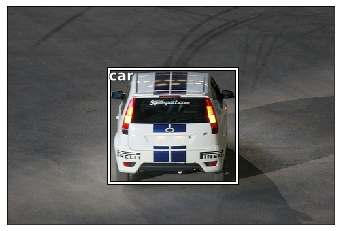

In [54]:
ax = show_img(im)
img_id = trn_data[IMAGES][0][ID]
bbox, cat_id = trn_anno[img_id][0]
bbox = bb_hw(bbox)
#print(trn_anno[img_id][1])
cat = trn_cat[cat_id]
draw_text(ax, (bbox[0], bbox[1]), cat)
draw_rect(ax, bbox)

In [55]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], trn_cat[c], sz=16)

In [56]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(img_path/trn_fnm[i])
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


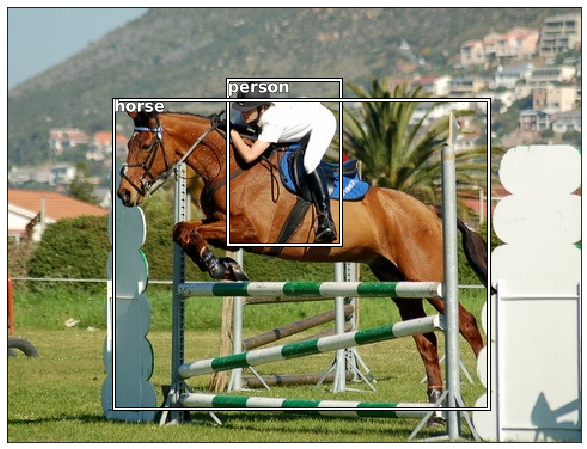

In [57]:
draw_idx(17)

In [58]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [59]:
#Now we have a dictionary from image id to a single bounding box - the largest for that image.
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

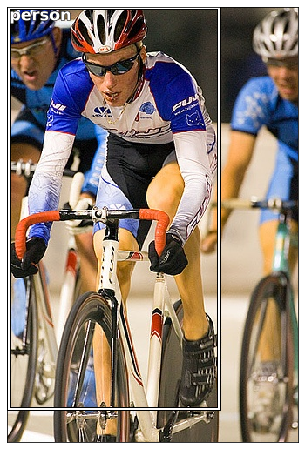

In [60]:
img_name = trn_fnm[23]
ax = show_img(open_image(img_path/img_name), figsize=(15, 8))
(b, c) = trn_lrg_anno[23]
b = bb_hw(b)
draw_rect(ax, b)
draw_text(ax, b[:2], trn_cat[c], 16)

In [61]:
(PATH/'tmp').mkdir(exist_ok = True)
CSV = PATH/'tmp/lrg.csv'

In [62]:
df = pd.DataFrame({'fn': [trn_fnm[o] for o in trn_ids],                  
                   'cat': [trn_cat[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn', 'cat'])
df.to_csv(CSV, index=False)

In [63]:
f_model = resnet34
sz = 224
bs = 64
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [64]:
tfm_model = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfm_model, bs=bs)

In [89]:
md.

In [65]:
x,y = next(iter(md.val_dl))


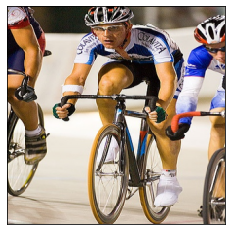

In [66]:
show_img(md.val_ds.denorm(to_np(x))[0]);

In [36]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [37]:
learn.lr_find(1e-5, 100)

 78%|███████▊  | 25/32 [00:13<00:01,  3.71it/s, loss=5.34]

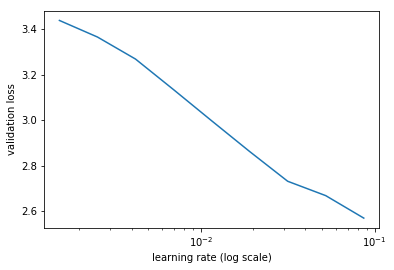

In [38]:
learn.sched.plot()

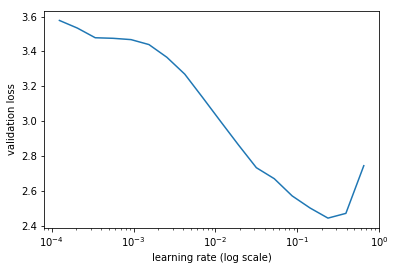

In [39]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [40]:
lr = 2e-2

In [41]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.307633   0.713361   0.806     


[array([0.71336]), 0.8059999990463257]

In [42]:
lrs = np.array([lr/1000,lr/100,lr])

In [43]:
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:17<00:02,  1.89it/s, loss=2.92] 

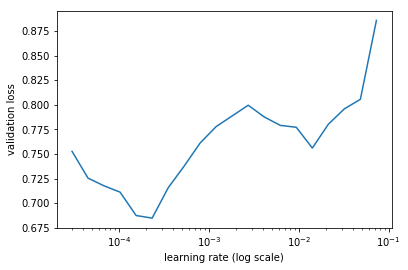

In [44]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [45]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.829937   0.643954   0.794     


[array([0.64395]), 0.7940000009536743]

In [46]:
learn.unfreeze()

In [47]:
learn.fit(lrs/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.63085    0.551133   0.822     
    1      0.449667   0.555639   0.818                     


[array([0.55564]), 0.8180000004768372]

In [48]:
learn.save('clas_one')

In [67]:
learn.load('clas_one')

NameError: name 'learn' is not defined

In [50]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


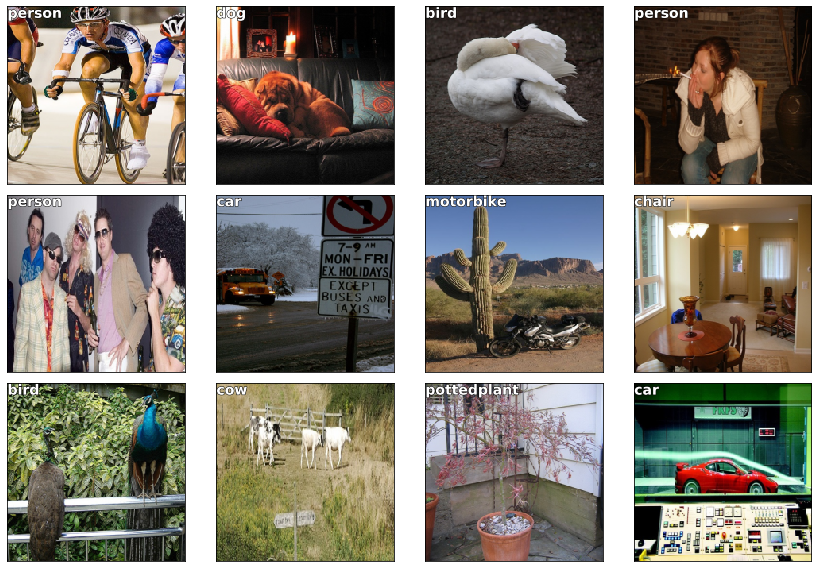

In [51]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, axes=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

In [68]:
BB = PATH/'tmp/bb.csv'

In [69]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]
df = pd.DataFrame({'fn': [trn_fnm[o] for o in trn_ids],
                  'bbox': bbs}, columns=['fn', 'bbox'])
df.to_csv(BB, index=False)

In [70]:
f_model = resnet34
sz = 224
bs = 64

In [63]:
augs = [RandomFlip(),
       RandomRotate(30),
       RandomLighting(0.1, 0.1)]

In [64]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB, bs=4, tfms=tfms, continuous=True)

[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]


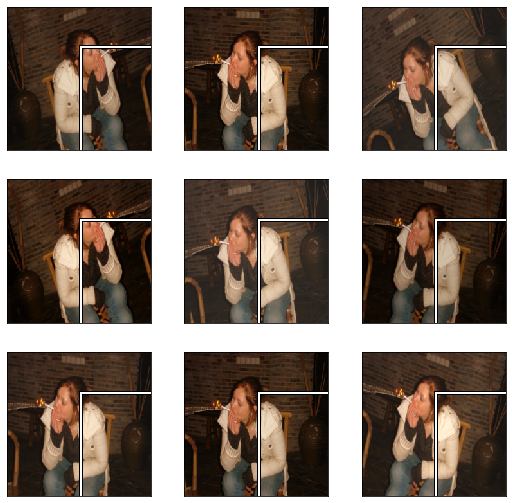

In [66]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, axes=ax)
    draw_rect(ax, b)

In [67]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
       RandomRotate(30, tfm_y=tfm_y),
       RandomLighting(0.1, 0.1, tfm_y=tfm_y)]

In [72]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB, bs=4, continuous=True, tfms=tfms)

[ 63.  36. 110. 187.]
[ 34.  20. 154. 203.]
[ 33.  18. 159. 205.]
[ 52.  19. 140. 204.]
[ 61.  31. 118. 192.]
[ 66.  38. 105. 183.]
[ 42.  28. 122. 195.]
[ 37.  22. 145. 201.]
[ 52.  38. 106. 183.]


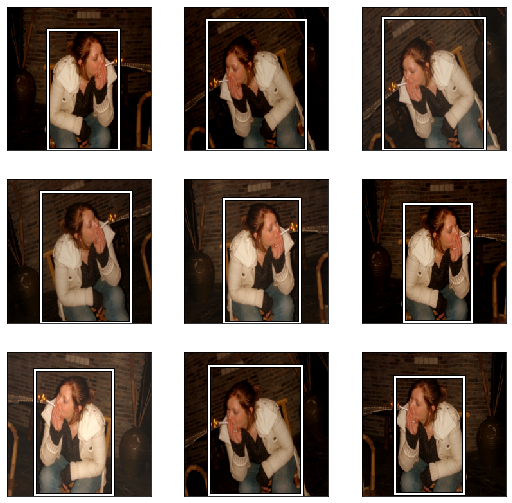

In [73]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, axes=ax)
    draw_rect(ax, b)

In [71]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB, tfms=tfms, bs=bs, continuous=True)

In [72]:
512*7*7

25088

In [73]:
head_reg = nn.Sequential(Flatten(), nn.Linear(25088, 4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg)
learn.optim_fn = optim.Adam
learn.crit = nn.L1Loss()

In [74]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

 69%|██████▉   | 22/32 [00:11<00:03,  2.72it/s, loss=333] 

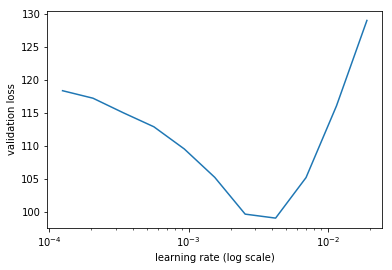

In [75]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [76]:
lr = 2e-3

In [77]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      51.822785  33.759011 
    1      38.766728  29.202926                           
    2      32.069236  27.079591                           


[array([27.07959])]

In [78]:
lrs = np.array([lr/100,lr/10,lr])

In [79]:
learn.freeze_to(-2)

 97%|█████████▋| 31/32 [00:21<00:00,  1.91it/s, loss=72.4]

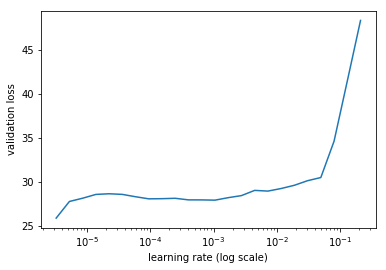

In [80]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [81]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      26.147876  24.955844 
    1      24.425391  22.839824                           
    2      21.840944  22.236826                           


[array([22.23683])]

In [82]:
learn.freeze_to(-3)

In [83]:
learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss                            
    0      19.829162  21.907852 
    1      18.764159  21.68246                            


[array([21.68246])]

In [84]:
learn.save('reg4')

In [85]:
learn.load('reg4')

In [86]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


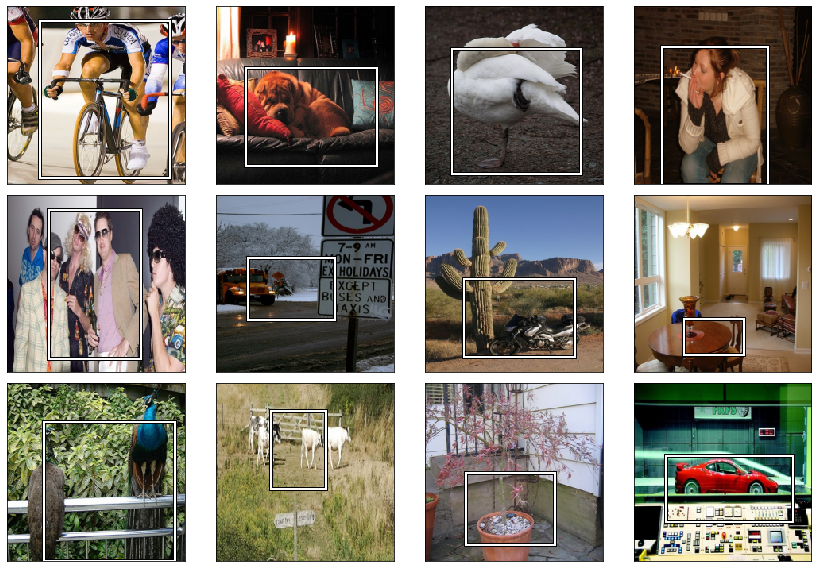

In [88]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, axes=ax)
    draw_rect(ax, b)
plt.tight_layout()

 ## Single Object Detection